/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


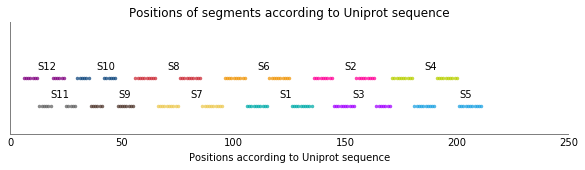

1891 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.



/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [3]:
import itertools
import sys
%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks04'
image_counter = Counter()
from IPython.html.widgets.widget_float import FloatProgress
import matplotlib as mpl

## Epistasis calculated every pair of mutations based on foursomes wt >mutA, mutB > mutAB

#### Reading foursomes from files, calculating epistasis and other parameters

In [15]:
from multiprocessing import Pool

In [14]:
def get_epistasis_values(hdf_file_foursomes, minimal_threshold=20):
    mutA, mutB = hdf_file_foursomes.rstrip('.hdf').split('_')[-3], hdf_file_foursomes.rstrip('.hdf').split('_')[-1]
    if mutA in unique_single_mutations[segment] and mutB in unique_single_mutations[segment]:
        foursome = pd.read_hdf(directory + hdf_file_foursomes, 'data')
        if len(foursome['wild_type']) > minimal_threshold:
            ep = foursome['wild_type']['mut_list_Scer'].apply(lambda wt: foursome_epistasis(foursome, wt))
#             background_fitness = foursome['wild_type']['s']
#             mutA_impacts = foursome['mutA']['s'] - foursome['wild_type']['s']
#             mutB_impacts = foursome['mutB']['s'] - foursome['wild_type']['s']
#             mutAB_impacts = foursome['mutAB']['s'] - foursome['wild_type']['s']
            ep.to_hdf(directory_to_save + hdf_file_foursomes.strip('.hdf') + '--epistasis_values.hdf', 'data')
        else:
            return None

In [ ]:
for segment in data:
    print segment, '...'
    sys.stdout.flush()
    directory = check_dir('/Users/karen/Downloads/foursomes_full_lib/'+segment.split('_')[0]+'/')
    directory_to_save = check_dir('/Users/karen/Downloads/foursomes_full_lib_epistasis/'+segment.split('_')[0]+'/')
    list_of_files = [f for f in os.listdir(directory) if '.hdf' in f]
    pool = Pool(8)
    pool.map(get_epistasis_values, list_of_files)

S1_scaled ...
S2_scaled ...


#### Producing many figures of epistasis distribution

S1_scaled ...
S2_scaled ...
S3_scaled ...


KeyboardInterrupt: 

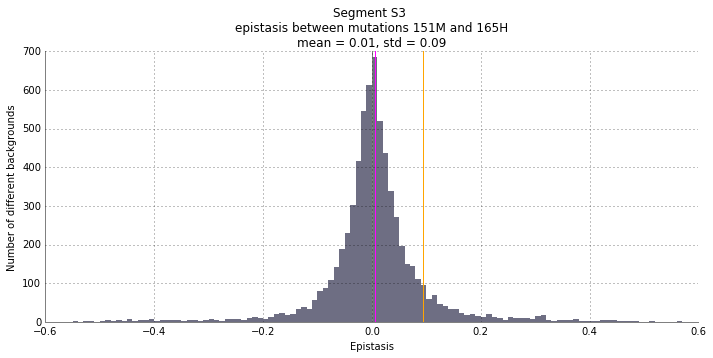

In [91]:
bar_color = '#6e6e83'
minimal_backgrounds_cutoff = 20
for segment in data:
    print segment, '...'
    folder_to_save = check_dir(os.path.join(figures_folder, 'epistasis_histograms', segment, ''))
    for mutA, mutB in ep_dict[segment]:
        ep = ep_dict[segment][mutA, mutB][1]
        if len(ep) > minimal_backgrounds_cutoff:
            plot_better()
            mean, std = ep.mean(), ep.std()
            plt.axvline(mean, color='magenta')
            plt.axvline(std, color='orange')
            title = 'Segment %s \nepistasis between mutations %s and %s\nmean = %.2f, std = %.2f' %(segment.split('_')[0], 
                                                                                                mutA, mutB,
                                                                                               mean, std)
            plt.hist(ep.values, edgecolor='none', range=(-0.6, 0.6), bins=120, color=bar_color)
            plt.title(title)
            plt.xlabel('Epistasis')
            plt.ylabel('Number of different backgrounds')
            plt.xlim(-0.6,0.6)
            plt.axvline(0, color='gray', ls='-')
            plt.tight_layout()
            save_image(image_counter, title[:title.index('\nmean')], 
                       check_dir(os.path.join(folder_to_save, 'positions_'+mutA[:-1]+'-'+mutB[:-1], '')), 
                       notebook_prefix)
            plt.close()

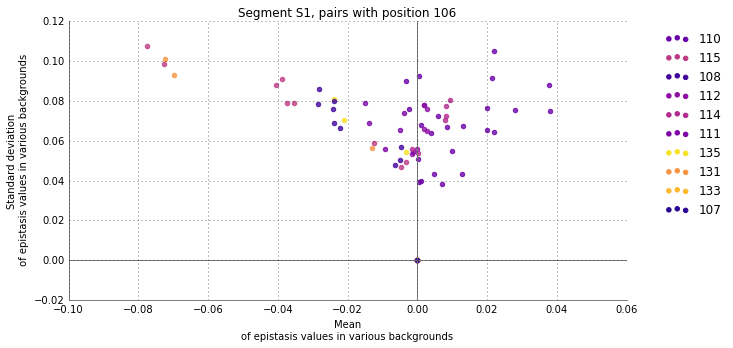

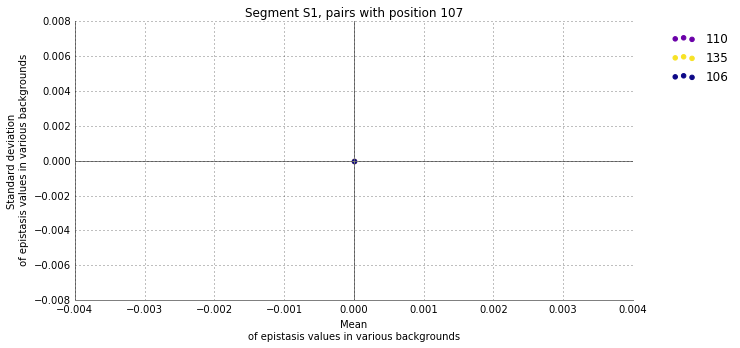

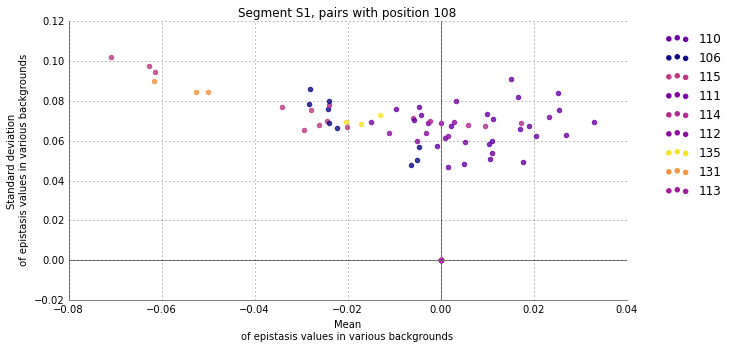

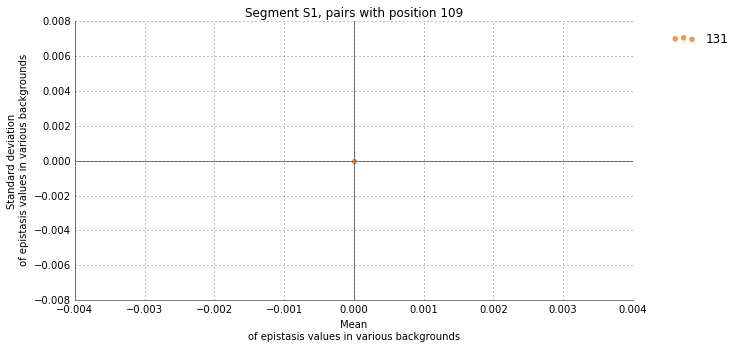

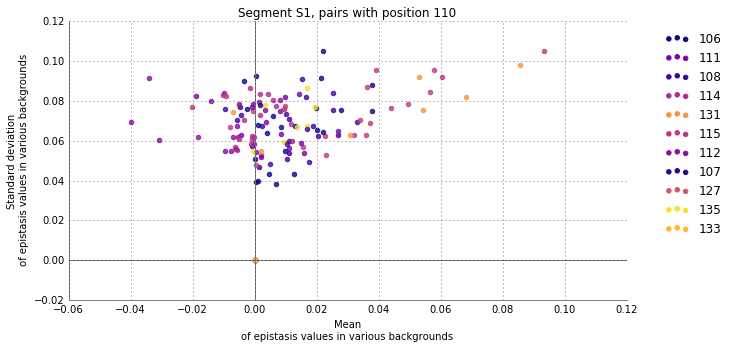

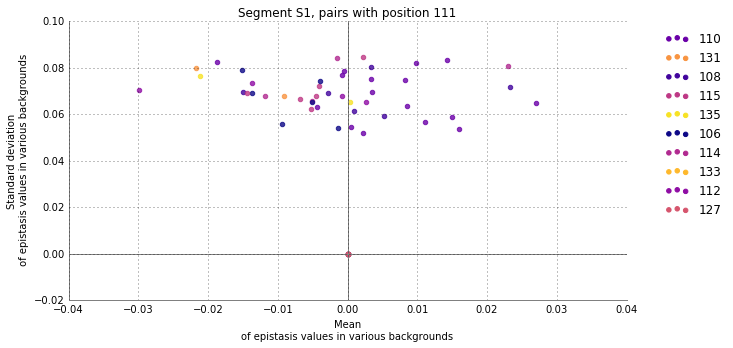

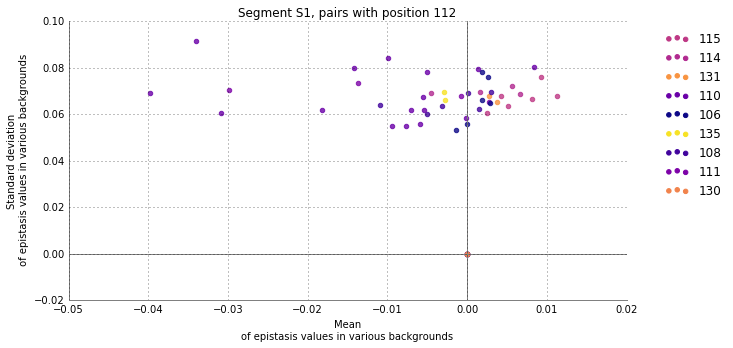

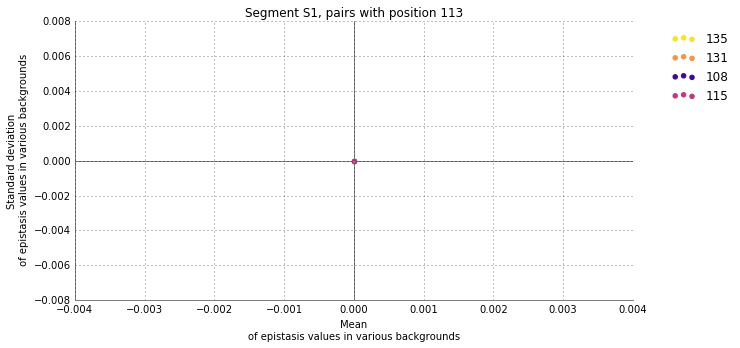

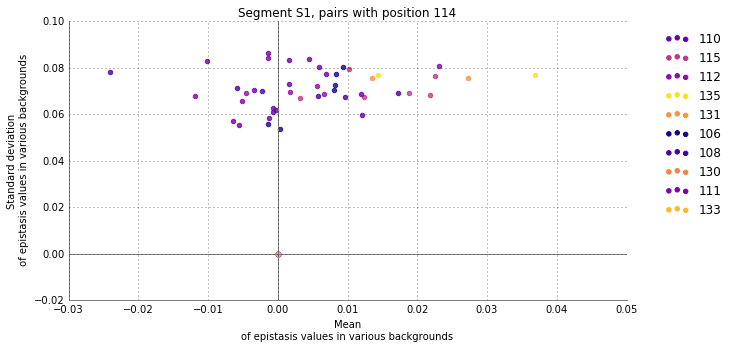

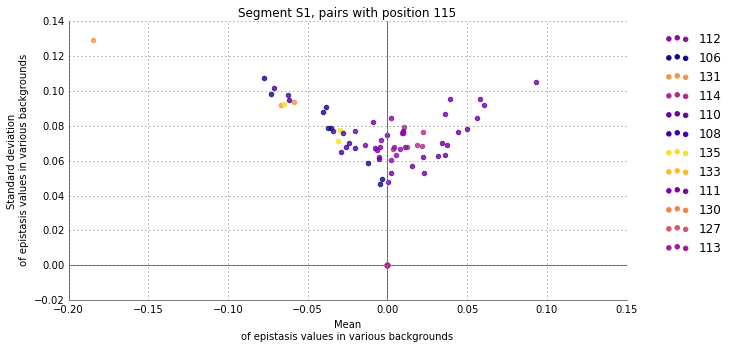

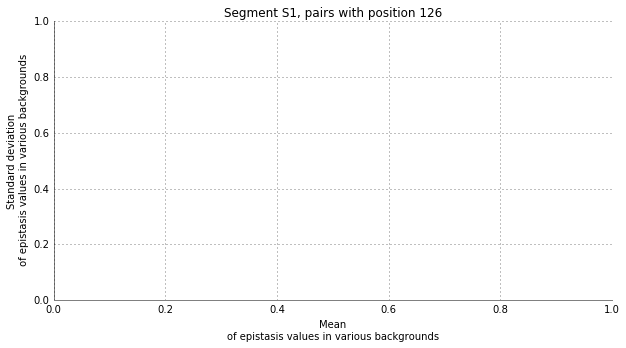

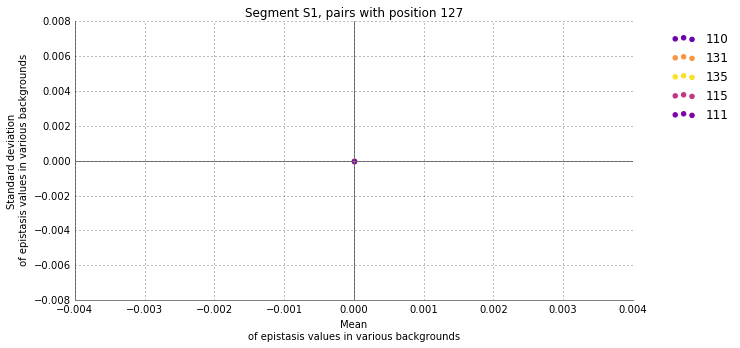

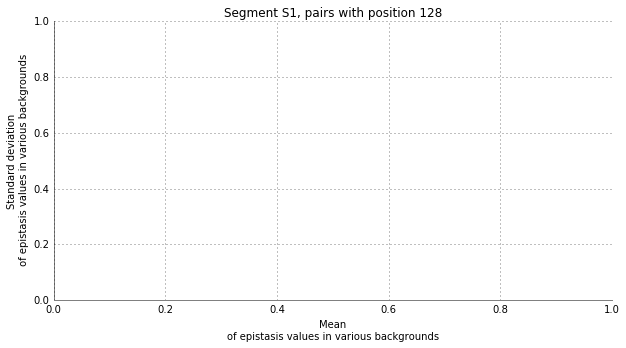

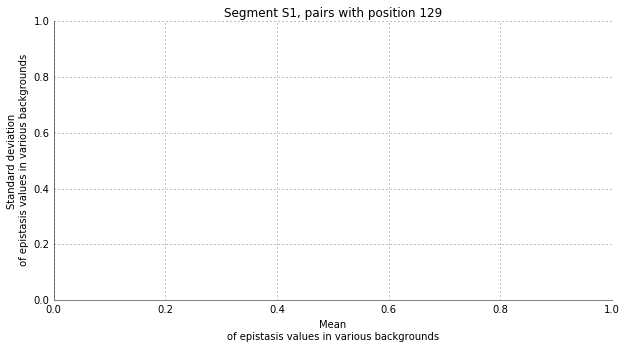

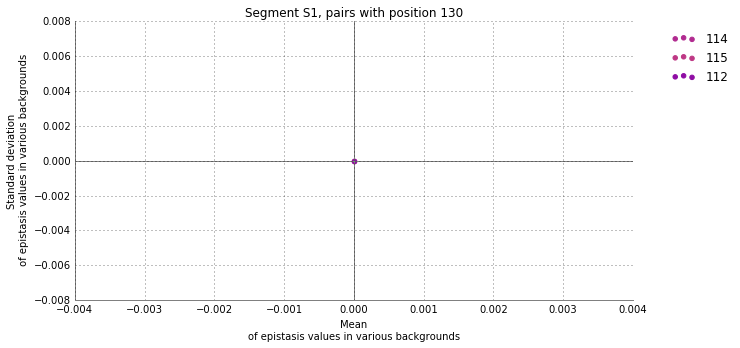

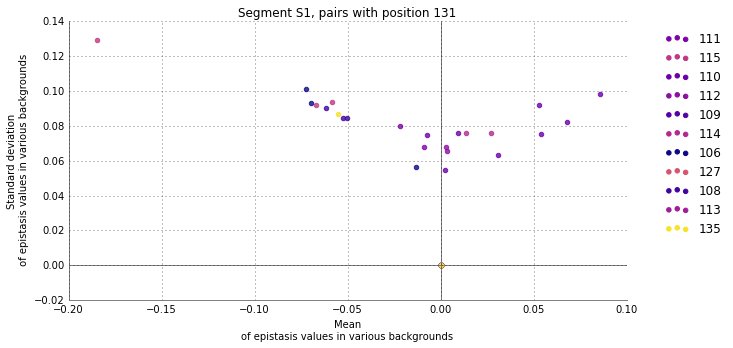

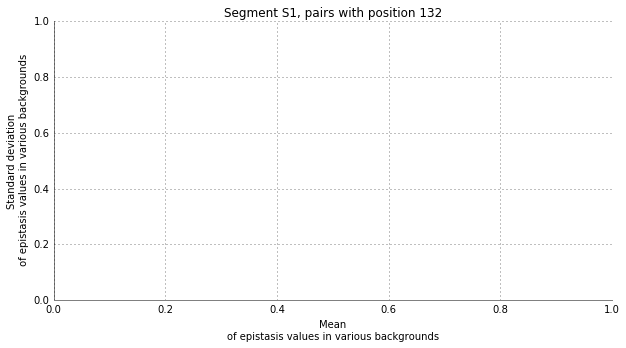

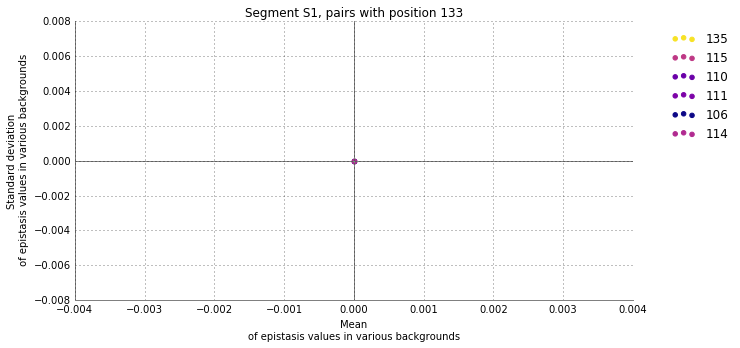

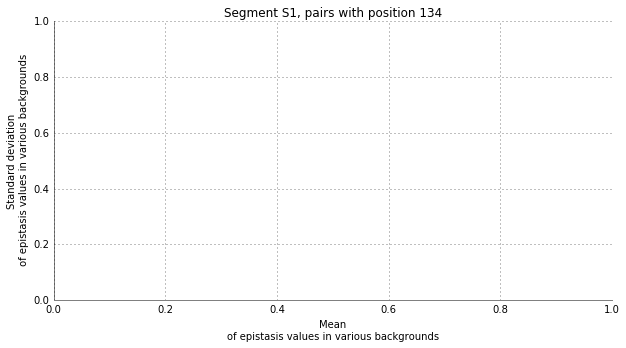

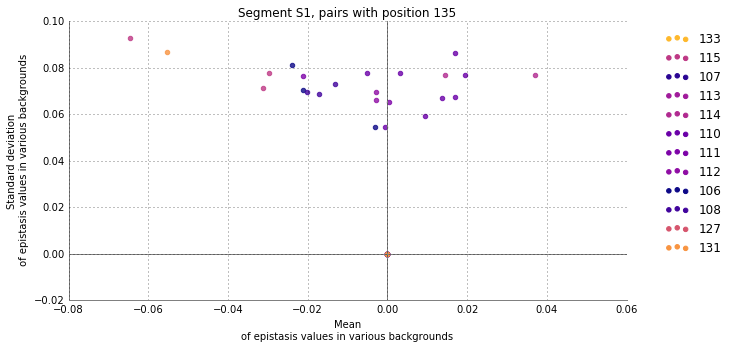

In [65]:
colormap = mpl.cm.plasma
for segment in data:
    positions = sorted(list(set([int(m[:-1]) for m in unique_single_mutations[segment]])))
    for position in positions:
        plot_better()
        already = []
        for mutA, mutB in ep_dict[segment]:
            if str(position) == mutA[:-1] or str(position) == mutB[:-1]:
                if str(position) == mutA[:-1]:
                    other_position = int(mutB[:-1])
                if str(position) == mutB[:-1]:
                    other_position = int(mutA[:-1])
                color_value = int(float(positions.index(other_position)) / len(positions) * 255)
                color = colormap(color_value)
                if not other_position in already:
                    plt.scatter(0,0, color=color, label=other_position)
                    already.append(other_position)
                ep = ep_dict[segment][mutA, mutB][1]
                if len(ep) > 10:
                    plt.scatter(ep.mean(), ep.std(), alpha=0.8, color=color)
        plt.legend(loc=2, bbox_to_anchor=(1.05, 1), frameon=False)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        title = 'Segment %s, pairs with position %s' %(segment.split('_')[0], position)
        plt.title(title)
        plt.xlabel('Mean\nof epistasis values in variouiis backgrounds')
        plt.ylabel('Standard deviation\n of epistasis values in various backgrounds')
    #     save_image(image_counter, title, figures_folder, notebook_prefix)
    break

# Trash

In [ ]:
from scipy.stats import norm
counter = 0

for mutA, mutB in ep_dict:
    plot_better()
    title = 'Epistasis in pairs in all backgrounds\nmutations %s and %s' %(mutA, mutB)
    title += '\nstd = %.2f, skew = %.2f' %(ep.std(), ep.skew())
    ep = ep_dict[mutA, mutB][1]
    counter += 1
    plt.title(title)
    plt.hist(ep, edgecolor='none', bins=80, color='black', alpha=0.5, normed=True);
    plt.axvline(ep.std(), color='orange')
    plt.axvline(ep.mean(), color='green')
    plt.axvline(ep.skew(), color='red')
    plt.xlim(-0.6, 0.6)
    
    if counter > 40:
        break

#### Plotting

In [57]:
alpha = 0.4
wt_color = 'magenta'
mutA_color = 'green'
mutB_color = 'orange'

foursomes_folder = os.path.join(figures_folder, 'foursomes_nat')
for k,v in ep_dict.items():
    foursome, ep, mutA_impacts, mutB_impacts  = v
    plot_better()
    plt.scatter(foursome['wild_type']['s'].values, ep.values, edgecolor='none', color='black', alpha=0.05);
    title = 'Epistasis in foursomes with mutations %s and %s' %(k[0], k[1])
    plt.title(title + '\nN = %s' %len(foursome['wild_type']))
    plt.axvline(wt_fitness, color=wt_color, alpha=alpha)
    plt.text(0.52, 0.42, 'wild type', color=wt_color, alpha=alpha)
    plt.axhline(0, color='gray', alpha=0.4)
    
    plt.axvline(wt_fitness + mutA_impacts.median(), color=mutA_color, ls='-', alpha=alpha)
    plt.axvline(wt_fitness + mutB_impacts.median(), color=mutB_color, ls='-', alpha=alpha)

    try:
#         plt.axvline(single_mut_fitness_dict[k[0]], color=mutA_color, alpha=alpha)
#         plt.axvline(single_mut_fitness_dict[k[1]], color=mutB_color, alpha=alpha)
        plt.text(0.52, 0.52, 'median impact of %s' % k[0], color=mutA_color, alpha=alpha)
        plt.text(0.52, 0.47, 'median impact of %s' % k[1], color=mutB_color, alpha=alpha)
    except:
        pass
    plt.xlim(0, 0.6)
    plt.ylim(-0.6, 0.6)
    plt.xlabel('Fitness of a "wild type" combination')
    plt.ylabel('Epistasis in a foursome')
    save_image(image_counter, title, foursomes_folder, notebook_prefix)
    plt.close()

In [ ]:
plot_better()
for k,v in ep_dict.items():
    mutA, mutB = k
    foursome, ep, mutA_impacts, mutB_impacts  = v
    try:
        plt.scatter(single_mut_fitness_dict[mutA], mutA_impacts.median(), edgecolor='none', alpha=0.1)
        plt.scatter(single_mut_fitness_dict[mutB], mutB_impacts.median(), edgecolor='none', alpha=0.1)
    except KeyError:
        pass

# 123

In [98]:
from collections import defaultdict

In [12]:
epistasis_by_positions = OrderedDict()
for segment in ep_dict:
    epistasis_by_positions[segment] = OrderedDict()
    mutA_positions = set(mutA[:-1] for mutA, mutB in ep_dict[segment])
    mutB_positions = set(mutB[:-1] for mutA, mutB in ep_dict[segment])
    all_positions = sorted(list(set.union(mutA_positions, mutB_positions)), key=lambda s: int(s))
    for position1 in all_positions:
        epistasis_by_positions[segment][position1] = OrderedDict()
        for position2 in all_positions:
            if position1 != position2:
                epistasis_by_positions[segment][position1][position2] = defaultdict(list)

In [13]:
for segment in ep_dict:
    for mutA, mutB in ep_dict[segment]:
        posA, posB = mutA[:-1], mutB[:-1]
        ep = ep_dict[segment][mutA, mutB][1]
        if len(ep) > 20:
            std = ep.std()
            mean = ep.mean()
            epistasis_by_positions[segment][posA][posB]['std'].append(std)
            epistasis_by_positions[segment][posA][posB]['mean'].append(mean)
            epistasis_by_positions[segment][posB][posA]['std'].append(std)
            epistasis_by_positions[segment][posB][posA]['mean'].append(mean)

In [15]:
pd.DataFrame.from_dict(epistasis_by_positions['S1_scaled'])

,106,107,108,109,110,111,112,113,114,115,127,130,131,133,135
106,NaN,{},"{u'std': [0.0758829525463, 0.0476136516391, 0....",{},"{u'std': [0.0385166126796, 0.0897466433763, 0....","{u'std': [0.0741274587448, 0.0689914605469, 0....","{u'std': [0.0559116661648, 0.0758669113557, 0....",{},"{u'std': [0.0724998219303, 0.0772528667989, 0....","{u'std': [0.0789026075905, 0.078719805488, 0.0...",{},{},"{u'std': [0.056517035146, 0.101184231894, 0.09...",{},"{u'std': [0.07059931841, 0.0543764903539, 0.08..."
107,{},NaN,{},{},{},{},{},{},{},{},{},{},{},{},{}
108,"{u'std': [0.0758829525463, 0.0476136516391, 0....",{},NaN,{},"{u'std': [0.0734601674647, 0.0510096307676, 0....","{u'std': [0.0689627485172, 0.0801223637483, 0....","{u'std': [0.0694957699958, 0.0637205356288, 0....",{},"{u'std': [0.0677894288606, 0.0781644597724, 0....","{u'std': [0.067957247498, 0.0700277098808, 0.0...",{},{},"{u'std': [0.0900206463966, 0.084611110484, 0.0...",{},"{u'std': [0.0695842547593, 0.0728766721175, 0...."
109,{},{},{},NaN,{},{},{},{},{},{},{},{},{},{},{}
110,"{u'std': [0.0385166126796, 0.0897466433763, 0....",{},"{u'std': [0.0734601674647, 0.0510096307676, 0....",{},NaN,"{u'std': [0.0785923738284, 0.0545970584703, 0....","{u'std': [0.0549798591623, 0.0691744974152, 0....",{},"{u'std': [0.0803510039477, 0.0610188473028, 0....","{u'std': [0.0531059196098, 0.0954360488863, 0....",{},{},"{u'std': [0.0754745518784, 0.076022610673, 0.0...",{},"{u'std': [0.0591618240649, 0.0775655383911, 0...."
111,"{u'std': [0.0741274587448, 0.0689914605469, 0....",{},"{u'std': [0.0689627485172, 0.0801223637483, 0....",{},"{u'std': [0.0785923738284, 0.0545970584703, 0....",NaN,"{u'std': [0.0678311444003, 0.0652760598279, 0....",{},"{u'std': [0.0840617756317, 0.0805905483319, 0....","{u'std': [0.0719354216081, 0.067701692798, 0.0...",{},{},"{u'std': [0.0799403540187, 0.0678899853997], u...",{},"{u'std': [0.0762435632463, 0.0652600283491], u..."
112,"{u'std': [0.0559116661648, 0.0758669113557, 0....",{},"{u'std': [0.0694957699958, 0.0637205356288, 0....",{},"{u'std': [0.0549798591623, 0.0691744974152, 0....","{u'std': [0.0678311444003, 0.0652760598279, 0....",NaN,{},"{u'std': [0.0694705417669, 0.0692642919496, 0....","{u'std': [0.0665327943597, 0.0603921593169, 0....",{},{},"{u'std': [0.0677223722797, 0.0653039428769], u...",{},"{u'std': [0.0661958051311, 0.0696915340279], u..."
113,{},{},{},{},{},{},{},NaN,{},{},{},{},{},{},{}
114,"{u'std': [0.0724998219303, 0.0772528667989, 0....",{},"{u'std': [0.0677894288606, 0.0781644597724, 0....",{},"{u'std': [0.0803510039477, 0.0610188473028, 0....","{u'std': [0.0840617756317, 0.0805905483319, 0....","{u'std': [0.0694705417669, 0.0692642919496, 0....",{},NaN,"{u'std': [0.0794035905292, 0.0691270609472, 0....",{},{},"{u'std': [0.0757562674656, 0.0757099473406], u...",{},"{u'std': [0.0769681996385, 0.0767966843981], u..."
115,"{u'std': [0.0789026075905, 0.078719805488, 0.0...",{},"{u'std': [0.067957247498, 0.0700277098808, 0.0...",{},"{u'std': [0.0531059196098, 0.0954360488863, 0....","{u'std': [0.0719354216081, 0.067701692798, 0.0...","{u'std': [0.0665327943597, 0.0603921593169, 0....",{},"{u'std': [0.0794035905292, 0.0691270609472, 0....",NaN,{},{},"{u'std': [0.0921175165282, 0.0933855775962, 0....",{},"{u'std': [0.077678549277, 0.0712605728042, 0.0..."


In [19]:
ep_std_by_position = {}
for segment in epistasis_by_positions:
    ep_std_by_position[segment] = {}
    for position in epistasis_by_positions[segment]:
        other_positions = epistasis_by_positions[segment][position].keys()
        other_positions = [p for p in other_positions if len(epistasis_by_positions[segment][position][p]['std']) > 0]
        values = [max(epistasis_by_positions[segment][position][p]['std']) for p in other_positions \
                  if len(epistasis_by_positions[segment][position][p]['std']) > 0]
        ep_std_by_position[segment][position] = other_positions, values

In [20]:
pdb_file = files_dump_folder
cmd.reinitialize()
open_or_fetch(pdb_file)
white_and_beautiful()
color_positions(positions, values=impacts, representation='lines')
cmd.hide('everything', '4LOM')
cmd.color('orange', 'ligand')
cmd.show('spheres', 'ligand')

NameError: name 'pdb_file' is not defined